In [ ]:
# Generic # 40 Epochs - 32 patch
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# TensorFlow
from transformers import ViTFeatureExtractor, ViTForImageClassification

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
# Dataset parameters
dataset_path = '/content/drive/MyDrive/Dataset'
categories = ['Tablet_Sheets', 'Ointments', 'Medicine_Bottles', 'Face_Masks', 'Syringes', 'Covid_Test_Kits', 'Asthma_Inhalers']
risks = ['High_Risk', 'Medium_Risk', 'Low_Risk']
image_size = (224, 224)

# Data preprocessing
X = []
y = []

for category in categories:
    for risk in risks:
        risk_path = os.path.join(dataset_path, category, risk)
        for image_file in os.listdir(risk_path):
            image = Image.open(os.path.join(risk_path, image_file))
            if image.mode == 'RGBA':
                image = image.convert('RGB')

            # Resize the image
            image = image.resize(image_size)
            # Convert to numpy array and reshape to include channel dimension
            image = np.array(image)
            image = np.transpose(image, (2, 0, 1))  # Swap dimensions to (channels, height, width)
            X.append(image)
            y.append(risks.index(risk))

# Convert the lists to numpy arrays
X = np.array(X)
y = np.array(y)

# Normalize the pixel values to be between 0 and 1
X = X / 255.0

# Convert data to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# Create dataset and DataLoader
dataset = TensorDataset(X_tensor, y_tensor)

# Split the dataset into train, validation, and test sets
train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# DataLoader
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Load ViT feature extractor and model for ViT-B/32
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch32-224-in21k')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch32-224-in21k', num_labels=len(risks)).to(device)

In [ ]:
# Training loop
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# Lists to store losses
train_losses = []
val_losses = []

for epoch in range(40):  # Train for 20 epochs
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(pixel_values=inputs)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.logits.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(pixel_values=inputs)
            loss = criterion(outputs.logits, labels)
            val_loss += loss.item()
            _, predicted = outputs.logits.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    val_loss /= len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)

    print(f'Epoch [{epoch+1}/40], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')


Epoch [1/40], Train Loss: 1.0464, Train Acc: 0.4127, Val Loss: 0.9966, Val Acc: 0.6667
Epoch [2/40], Train Loss: 0.7600, Train Acc: 0.9524, Val Loss: 0.7978, Val Acc: 0.8095
Epoch [3/40], Train Loss: 0.4785, Train Acc: 0.9841, Val Loss: 0.6201, Val Acc: 0.8095
Epoch [4/40], Train Loss: 0.2663, Train Acc: 1.0000, Val Loss: 0.5934, Val Acc: 0.8095
Epoch [5/40], Train Loss: 0.1423, Train Acc: 1.0000, Val Loss: 0.4634, Val Acc: 0.8333
Epoch [6/40], Train Loss: 0.0847, Train Acc: 1.0000, Val Loss: 0.4310, Val Acc: 0.8571
Epoch [7/40], Train Loss: 0.0600, Train Acc: 1.0000, Val Loss: 0.3975, Val Acc: 0.8333
Epoch [8/40], Train Loss: 0.0479, Train Acc: 1.0000, Val Loss: 0.4035, Val Acc: 0.8571


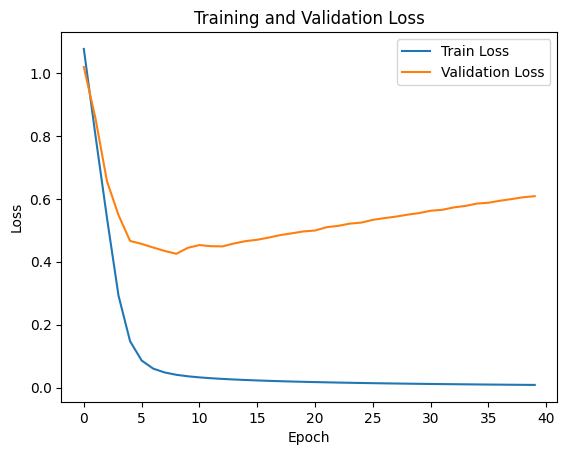

In [ ]:
# Plotting training and validation loss
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
# Testing loop
test_loss = 0.0
correct = 0
total = 0
predicted_labels = []
true_labels = []
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(pixel_values=inputs)
        loss = criterion(outputs.logits, labels)
        test_loss += loss.item()
        _, predicted = outputs.logits.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
test_loss /= len(test_loader)
test_acc = correct / total

print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

Test Loss: 1.0333, Test Acc: 0.6905


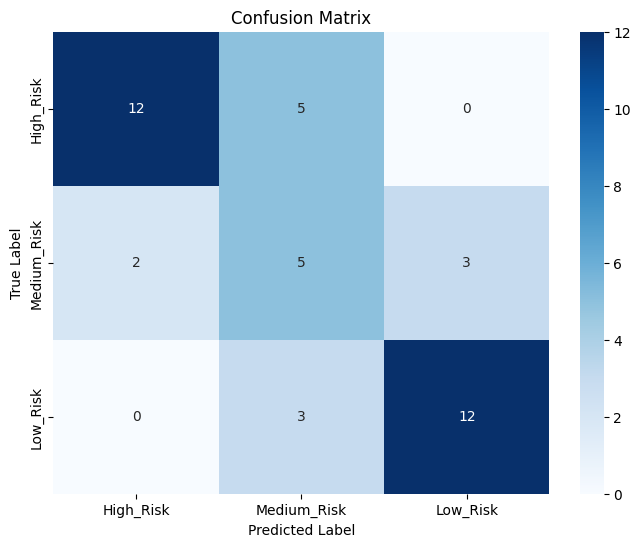

In [ ]:
# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=risks, yticklabels=risks)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()